In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from sympy import *
from tqdm import tqdm

from integrator_functions import euler_integrator_step, vel_verlet_integrator_step, leap_frog_integrator_step, acf


np.random.seed(0)

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

In [2]:
# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
beta  = 1 / kB / T  # kJ-1 mol
M     = 1           # amu

# Generalized Langevin Equation

\begin{cases}
\dot{Q} = \frac{P}{M} \, , \\
    \dot{P} 
    = 
    -\nabla V(Q(t)) 
    - \int_0^t ds\, \dot{Q} K(t-s)  
    + R(t) \, ,
\end{cases}

## Memory kernel

$$
K(t) = \sum_{i=1}^N k_i \cos(\omega_i t)
$$

## Noise term

$$
R(t) = 
\sqrt{\frac{1}{\beta}}
\sum_{i=1}^N 
\sqrt{k_i}
\left[
\xi_i \cos(\omega_i t)
+ 
\eta_i
\sin(\omega_i t)
\right] \, ,
$$
with $\xi, \eta_i \in \mathcal{N}(0,1)$.


## Second Fluctuation-Dissipation theorem

$$
\langle R(0) R(t) \rangle = \frac{1}{\beta} K(t) \, ,
$$

where 
$$
\langle R(0)R(t) \rangle = 
\frac{1}{T-t}
\int_0^{T-t} ds \, R(s)R(s+t) =
\lim_{N\rightarrow \infty}
\frac{1}{N} \sum_i^{N-n} R_i R_{i+n}
$$

with $t=n\Delta t$, is the autocorrelation function.


In [3]:
a       = 0.3333

gamma   = 1.5
alpha   = 100

D      = alpha ** 2 * M * gamma / beta
print( D / alpha  )


# Angular frequencies
def ang_freqs(omega, N):
    
    domega = N**a / N
    return ( 2 / np.pi ) * ( alpha ** 2 * M * gamma ) / ( alpha ** 2  + omega ** 2) * domega

# Memory kernel
def memory_kernel1( t, omega, k_spring ):

    return np.sum(  k_spring * np.cos( omega * t ) )

def f(t):
    return alpha * gamma * np.exp( - alpha * t )

# noise term
def noise_term( t, omega, k_spring, xi, eta ):
    return np.sqrt( 1 / beta ) * np.sum( np.sqrt( k_spring ) * ( xi * np.cos( omega * t ) + eta * np.sin( omega * t ) ) )      

374.15083500000003


In [8]:
Nreps   = 20

# Timeline
tmin    = 0
tmax    = 100
Nsteps  = 1000
tvalues = np.linspace( 0, tmax, Nsteps )
dt      = tvalues[1] - tvalues[0]
print(dt)

# Number of oscillators
N1 = 20
N2 = 200
N3 = 20000


# noise term
R1 = np.zeros((Nsteps, Nreps))
K1 = np.zeros((Nsteps, Nreps))

R2 = np.zeros((Nsteps, Nreps))
K2 = np.zeros((Nsteps, Nreps))

R3 = np.zeros((Nsteps, Nreps))
K3 = np.zeros((Nsteps, Nreps))

for r in tqdm(range(Nreps)):

    omega1    = np.random.uniform( 0, 1, N1 ) * N1 ** a
    k_spring1 = ang_freqs(omega1, N1)
    m1        = k_spring1 / omega1 ** 2
    
    omega2    = np.random.uniform( 0, 1, N2 ) * N2 ** a
    k_spring2 = ang_freqs(omega2, N2)
    m2        = k_spring2 / omega2 ** 2
    
    
    omega3    = np.random.uniform( 0, 1, N3 ) * N3 ** a
    k_spring3 = ang_freqs(omega3, N3)
    m3        = k_spring3 / omega3 ** 2
    
    # noise term
    xi1     = np.random.normal(0, 1, N1)
    eta1    = np.random.normal(0, 1, N1)
    
    xi2     = np.random.normal(0, 1, N2)
    eta2    = np.random.normal(0, 1, N2)
    
    xi3     = np.random.normal(0, 1, N3)
    eta3    = np.random.normal(0, 1, N3)
    
    for k,t in enumerate(tvalues):
        
        K1[k,r] = memory_kernel1( t, omega1, k_spring1 )
        K2[k,r] = memory_kernel1( t, omega2, k_spring2 )
        K3[k,r] = memory_kernel1( t, omega3, k_spring3 )
        
        R1[k,r] = noise_term( t, omega1, k_spring1, xi1, eta1 )
        R2[k,r] = noise_term( t, omega2, k_spring2, xi2, eta2 )
        R3[k,r] = noise_term( t, omega3, k_spring3, xi3, eta3 )

        
avgK1 = np.mean(K1, axis=1)
avgK2 = np.mean(K2, axis=1)
avgK3 = np.mean(K3, axis=1)

0.1001001001001001


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


In [9]:
# Autocorrelation
Ntau  = np.arange(int(Nsteps/1))

A1 = np.zeros((int(Nsteps/1), Nreps))
A2 = np.zeros((int(Nsteps/1), Nreps))
A3 = np.zeros((int(Nsteps/1), Nreps))

for t,tau in tqdm(enumerate(Ntau)):
    for k in range(Nsteps - tau):
        A1[t,:] = A1[t,:] + R1[k,:] * R1[k+tau,:]
        A2[t,:] = A2[t,:] + R2[k,:] * R2[k+tau,:]
        A3[t,:] = A3[t,:] + R3[k,:] * R3[k+tau,:]

    A1[t,:] = A1[t,:] / (Nsteps - tau)
    A2[t,:] = A2[t,:] / (Nsteps - tau)
    A3[t,:] = A3[t,:] / (Nsteps - tau)
    
Ac1 = np.mean(A1, axis=1)
Ac2 = np.mean(A2, axis=1)
Ac3 = np.mean(A3, axis=1)


1000it [00:04, 246.06it/s]


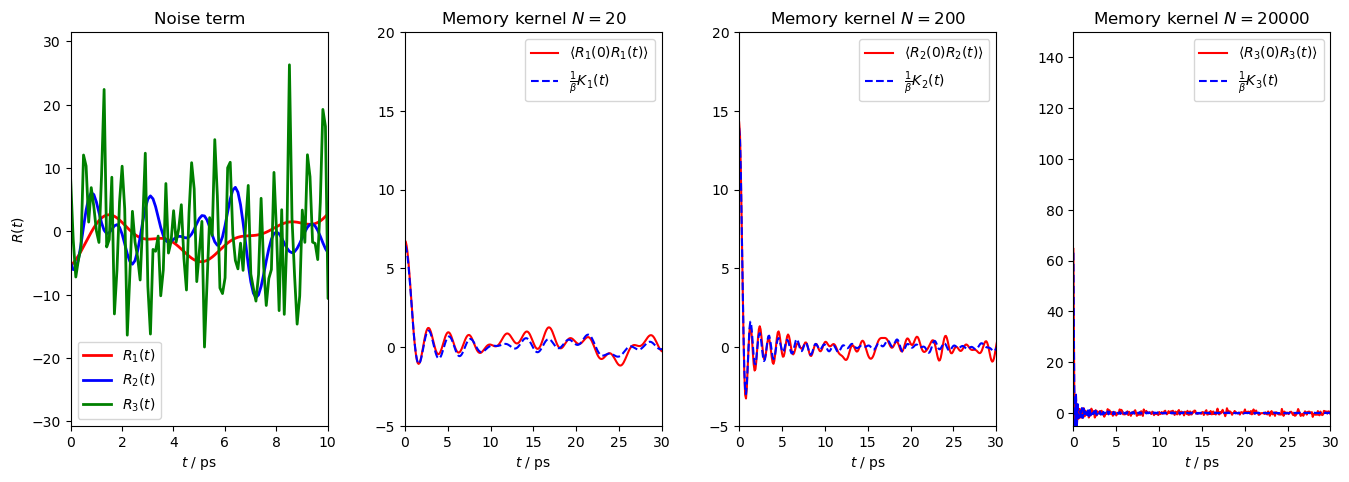

In [10]:
fig, ax = plt.subplots(1, 4,figsize=(32*in2cm, 10*in2cm))  

ax[0].plot(tvalues, R1[:,0], 'r-',    linewidth = 2,   label =r'$R_1(t)$')
ax[0].plot(tvalues, R2[:,0], 'b-',    linewidth = 2,   label =r'$R_2(t)$')
ax[0].plot(tvalues, R3[:,0], 'g-',    linewidth = 2,   label =r'$R_3(t)$')

ax[0].set_xlabel(r'$t$ / ps')
ax[0].set_ylabel(r'$R(t)$')

ax[0].set_title('Noise term')
ax[0].legend()
ax[0].set_xlim((0,10))


ax[1].plot(tvalues[0:int(Nsteps/1)], Ac1,  'r-' , label=r"$\langle R_1(0) R_1(t) \rangle$")
ax[1].plot(tvalues[0:int(Nsteps/1)], avgK1[0:int(Nsteps/1)] / beta,  'b--' , label=r"$\frac{1}{\beta}K_1(t)$")
ax[1].set_xlabel(r'$t$ / ps')
ax[1].set_title(r'Memory kernel $N=20$')
ax[1].set_xlim(0,30)
ax[1].set_ylim(-5,20)
ax[1].legend(loc="upper right")

ax[2].plot(tvalues[0:int(Nsteps/1)], Ac2,  'r-' , label=r"$\langle R_2(0) R_2(t) \rangle$")
ax[2].plot(tvalues[0:int(Nsteps/1)], avgK2[0:int(Nsteps/1)] / beta,  'b--' , label=r"$\frac{1}{\beta}K_2(t)$")
ax[2].set_xlabel(r'$t$ / ps')
ax[2].set_title(r'Memory kernel $N=200$')
ax[2].set_xlim(0,30)
ax[2].set_ylim(-5,20)
ax[2].legend()

ax[3].plot(tvalues[0:int(Nsteps/1)], Ac3,  'r-' , label=r"$\langle R_3(0) R_3(t) \rangle$")
ax[3].plot(tvalues[0:int(Nsteps/1)], avgK3[0:int(Nsteps/1)] / beta,  'b--' , label=r"$\frac{1}{\beta}K_3(t)$")
ax[3].set_xlabel(r'$t$ / ps')
ax[3].set_title(r'Memory kernel $N=20000$')

ax[3].set_xlim(0,30)
ax[3].set_ylim(-5,150)

ax[3].legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
fig.savefig('figures/noise_term_mem_kernel_2.png', format='png', dpi=900, bbox_inches='tight')

## Power spectrum analysis

Given a time-series $x(t)$, the Fourier transform is written as
$$
\hat{x}(\omega) = \int_{-\infty}^{\infty} dt\, x(t)\ e^{-i \omega t}
$$

The power spectrum is 
$$
S(\omega) = \lim_{t\to \infty} \frac 1 {2\pi t}  |\hat{x}_{t}(\omega)|^2 
$$

Variance 1
0.9926471617236652
0.9999999999999998
Variance 2
0.9991401644081732
1.0
Variance 3
1.0000489057119168
0.9999999999999998
Variance white noise
0.9999454650952753
0.989822314050133


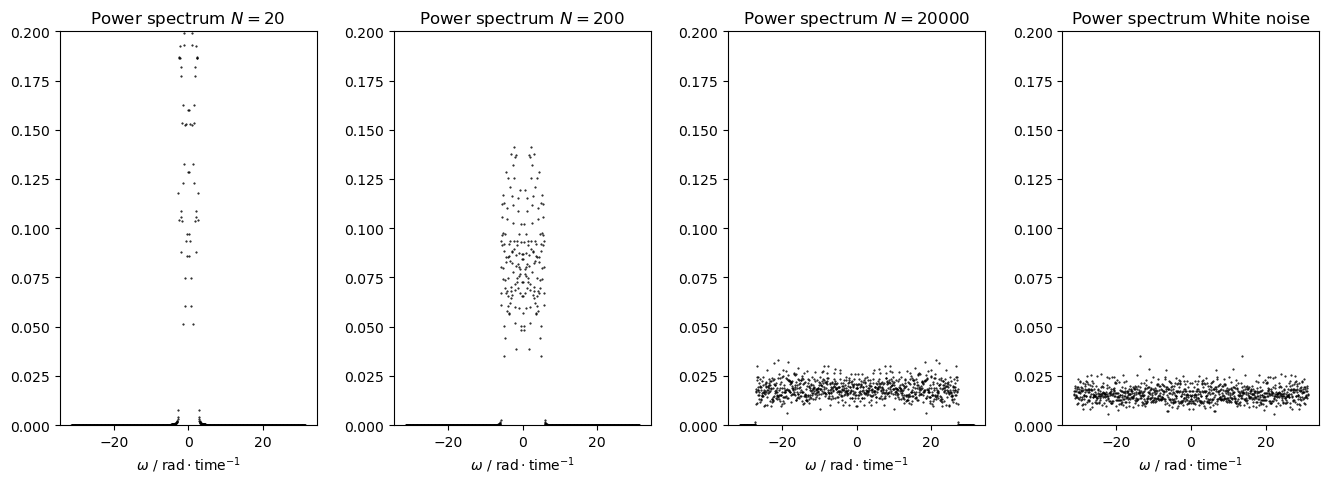

In [55]:
# Rotational frequencies
xi    = np.fft.fftfreq(Nsteps) * 1 / dt
dxi   = xi[1] - xi[0]

# Angular frequencies
omega  = 2 * np.pi * xi
domega =  omega[1] - omega[0]

# Generate white noise
eta    = np.random.normal(0, 1, (Nsteps,Nreps))

ps1 = np.zeros(Nsteps)
ps2 = np.zeros(Nsteps)
ps3 = np.zeros(Nsteps)
psW = np.zeros(Nsteps)

L      = 1 / ( 2 * np.pi * Nsteps * dt )

t0            = 0
prefactor_fft = np.exp( complex(0,1) * t0 * omega ) * dt

for r in range(Nreps):
    
    ft1 = prefactor_fft * np.fft.fft( R1[:,r]  / np.std( R1[:,r]  ) )
    ft2 = prefactor_fft * np.fft.fft( R2[:,r]  / np.std( R2[:,r]  ) )
    ft3 = prefactor_fft * np.fft.fft( R3[:,r]  / np.std( R3[:,r]  ) )
    ftW = prefactor_fft * np.fft.fft( eta[:,r] / np.std( eta[:,r] ) )

    ps1 = ps1 + L * np.abs( ft1 ) ** 2 
    ps2 = ps2 + L * np.abs( ft2 ) ** 2 
    ps3 = ps3 + L * np.abs( ft3 ) ** 2 
    psW = psW + L * np.abs( ftW ) ** 2 

ps1 = ps1 / Nreps
ps2 = ps2 / Nreps
ps3 = ps3 / Nreps
psW = psW / Nreps

# Variance - Parseval's theorem
print("Variance 1")
print(np.trapz(np.real(ps1) * domega ))
print(np.var(R1 / np.std(R1)))

print("Variance 2")
print(np.trapz(np.real(ps2) * domega ))
print(np.var(R2 / np.std(R2)))

print("Variance 3")
print(np.trapz(np.real(ps3) * domega ))
print(np.var(R3 / np.std(R3)))

print("Variance white noise")
print(np.trapz(np.real(psW) * domega ))
print(np.var(eta))

fig, ax = plt.subplots(1, 4,figsize=(32*in2cm, 10*in2cm))  

ax[0].plot(omega, ps1, 'k.', markersize = 1  )
ax[0].set_xlabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[0].set_title(r'Power spectrum $N=20$')
ax[0].set_ylim(0,0.2)

ax[1].plot(omega, ps2, 'k.', markersize = 1  )
ax[1].set_xlabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[1].set_title(r'Power spectrum $N=200$')
ax[1].set_ylim(0,0.2)

ax[2].plot(omega, ps3, 'k.', markersize = 1  )
ax[2].set_xlabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[2].set_title(r'Power spectrum $N=20000$')
ax[2].set_ylim(0,0.2)

ax[3].plot(omega, psW, 'k.', markersize = 1 )
ax[3].set_xlabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[3].set_title(r'Power spectrum White noise')
ax[3].set_ylim(0,0.2);
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
fig.savefig('figures/power_spectrum.png', format='png', dpi=900, bbox_inches='tight')

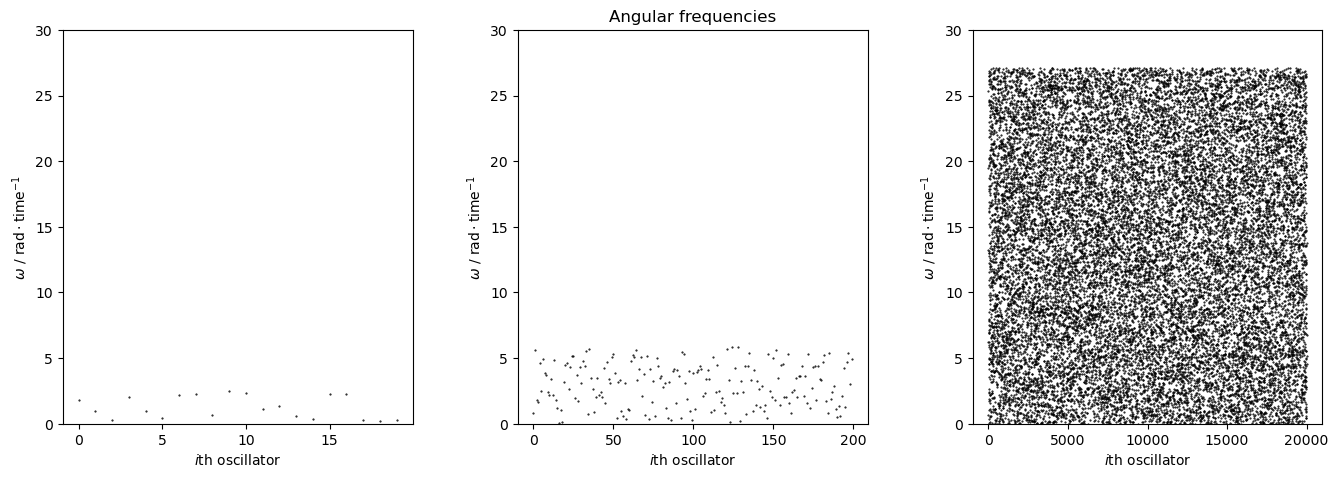

In [53]:
fig, ax = plt.subplots(1, 3,figsize=(32*in2cm, 10*in2cm))  
ax[0].plot(omega1, 'k.', markersize = 1  )
ax[0].set_xlabel(r'$i$th oscillator')
ax[0].set_ylabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[0].set_ylim(0, 30)

ax[1].plot(omega2, 'k.', markersize = 1  )
ax[1].set_xlabel(r'$i$th oscillator')
ax[1].set_ylabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[1].set_ylim(0, 30)
ax[1].set_title('Angular frequencies')

ax[2].plot(omega3, 'k.', markersize = 1  )
ax[2].set_xlabel(r'$i$th oscillator')
ax[2].set_ylabel(r"$\omega$ / $\rm rad \cdot time^{-1}$")
ax[2].set_ylim(0, 30)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
fig.savefig('figures/ang_frequencies.png', format='png', dpi=900, bbox_inches='tight')